# Day 2: Support Vector Machines (SVM) for Market Classification

## 🎯 Learning Objectives
- Understand SVM and maximum margin classifiers
- Apply kernel trick for non-linear patterns
- Tune SVM hyperparameters (C, gamma, kernel)
- Compare SVM vs Logistic Regression

---

## 📚 Theory: Support Vector Machines

### Maximum Margin Classifier
Find the hyperplane that maximizes the margin between classes:
$$\max_{w,b} \frac{2}{||w||}$$
subject to: $y_i(w^Tx_i + b) \geq 1$ for all $i$

### Soft Margin (C parameter)
Allow some misclassifications:
$$\min_{w,b,\xi} \frac{1}{2}||w||^2 + C\sum_{i=1}^n \xi_i$$

- **High C**: Fewer misclassifications, risk overfitting
- **Low C**: More margin violations, better generalization

### Kernel Trick
Map to higher dimensions without explicit computation:

| Kernel | Formula | Use Case |
|--------|---------|----------|
| Linear | $x^Ty$ | Linearly separable |
| RBF | $e^{-\gamma||x-y||^2}$ | Non-linear, general |
| Polynomial | $(\gamma x^Ty + r)^d$ | Interaction effects |

### Pros & Cons

| Pros | Cons |
|------|------|
| Effective in high dimensions | Slow for large datasets |
| Memory efficient (support vectors) | Sensitive to scaling |
| Versatile (kernel trick) | No probability output (need calibration) |
| Robust to overfitting | Hard to interpret |

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS', 'SPY']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(returns)} days")

📥 Downloading data...
✅ Data: 1253 days


In [2]:
# Feature Engineering
target_stock = 'AAPL'
df = pd.DataFrame(index=returns.index)

# Momentum
for lag in [1, 5, 10, 20]:
    df[f'momentum_{lag}'] = prices[target_stock].pct_change(lag)

# Volatility
df['volatility_10'] = returns[target_stock].rolling(10).std()
df['volatility_20'] = returns[target_stock].rolling(20).std()

# Moving averages
df['ma_ratio_5_20'] = prices[target_stock].rolling(5).mean() / prices[target_stock].rolling(20).mean() - 1
df['ma_ratio_10_50'] = prices[target_stock].rolling(10).mean() / prices[target_stock].rolling(50).mean() - 1

# RSI
delta = prices[target_stock].diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
df['rsi'] = 100 - (100 / (1 + gain / loss))

# Market
df['spy_return'] = returns['SPY']
df['spy_momentum'] = prices['SPY'].pct_change(5)

# Target
df['next_return'] = returns[target_stock].shift(-1)
df['target'] = (df['next_return'] > 0).astype(int)

df = df.dropna()
print(f"📊 Features: {len(df.columns)-2}, Samples: {len(df)}")

📊 Features: 11, Samples: 1204


In [3]:
# Prepare data
feature_cols = [c for c in df.columns if c not in ['target', 'next_return']]
X = df[feature_cols]
y = df['target']

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
returns_test = df['next_return'].iloc[split_idx:]

# CRITICAL: Scale for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 963, Test: 241


In [4]:
# Compare different kernels
kernels = ['linear', 'rbf', 'poly']
tscv = TimeSeriesSplit(n_splits=5)

print("\n" + "="*60)
print("KERNEL COMPARISON (Cross-Validation)")
print("="*60)

for kernel in kernels:
    svm = SVC(kernel=kernel, C=1.0, random_state=42)
    scores = cross_val_score(svm, X_train_scaled, y_train, cv=tscv, scoring='accuracy')
    print(f"{kernel.upper():<10} Accuracy: {scores.mean():.2%} ± {scores.std():.2%}")


KERNEL COMPARISON (Cross-Validation)
LINEAR     Accuracy: 51.12% ± 3.52%
RBF        Accuracy: 52.00% ± 2.28%
POLY       Accuracy: 51.25% ± 2.53%


In [5]:
# Hyperparameter tuning for RBF kernel
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 0.01]
}

svm_rbf = SVC(kernel='rbf', random_state=42)
grid_search = GridSearchCV(svm_rbf, param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"\n✅ Best Parameters: {grid_search.best_params_}")
print(f"   Best CV Accuracy: {grid_search.best_score_:.2%}")


✅ Best Parameters: {'C': 0.1, 'gamma': 'scale'}
   Best CV Accuracy: 52.62%


In [6]:
# Train final SVM with calibration for probabilities
best_svm = SVC(kernel='rbf', **grid_search.best_params_, random_state=42, probability=True)
best_svm.fit(X_train_scaled, y_train)

# Also train with calibration
svm_calibrated = CalibratedClassifierCV(SVC(kernel='rbf', **grid_search.best_params_, random_state=42), 
                                        cv=3, method='sigmoid')
svm_calibrated.fit(X_train_scaled, y_train)

# Logistic Regression for comparison
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

print("\n✅ Models trained: SVM (RBF), SVM (Calibrated), Logistic Regression")


✅ Models trained: SVM (RBF), SVM (Calibrated), Logistic Regression


In [7]:
# Predictions
models = {
    'SVM (RBF)': best_svm,
    'SVM (Calibrated)': svm_calibrated,
    'Logistic': lr
}

print("\n" + "="*70)
print("MODEL COMPARISON ON TEST SET")
print("="*70)

results = []
predictions = {}
probabilities = {}

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    predictions[name] = y_pred
    probabilities[name] = y_proba
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_proba)
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


MODEL COMPARISON ON TEST SET
           Model  Accuracy  Precision   Recall       F1  AUC-ROC
       SVM (RBF)  0.522822   0.522822 1.000000 0.686649 0.548309
SVM (Calibrated)  0.522822   0.524229 0.944444 0.674221 0.512560
        Logistic  0.514523   0.524590 0.761905 0.621359 0.506487


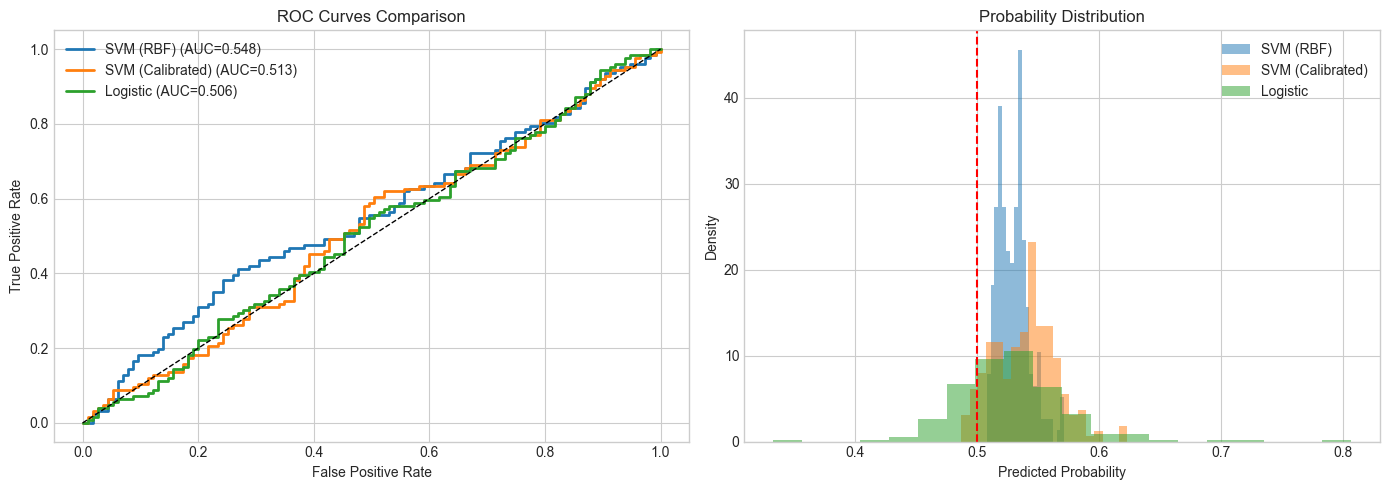

In [8]:
# ROC Curves Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curves
for name, proba in probabilities.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    axes[0].plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={auc:.3f})')

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves Comparison')
axes[0].legend()

# Probability calibration
for name, proba in probabilities.items():
    axes[1].hist(proba, bins=20, alpha=0.5, label=name, density=True)

axes[1].axvline(x=0.5, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Density')
axes[1].set_title('Probability Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

In [9]:
# Support Vectors Analysis
n_support = best_svm.n_support_
print(f"\n📊 Support Vector Analysis:")
print(f"   Total Support Vectors: {sum(n_support)}")
print(f"   Class 0 (Down): {n_support[0]}")
print(f"   Class 1 (Up): {n_support[1]}")
print(f"   % of Training Data: {sum(n_support) / len(X_train):.1%}")


📊 Support Vector Analysis:
   Total Support Vectors: 921
   Class 0 (Down): 451
   Class 1 (Up): 470
   % of Training Data: 95.6%


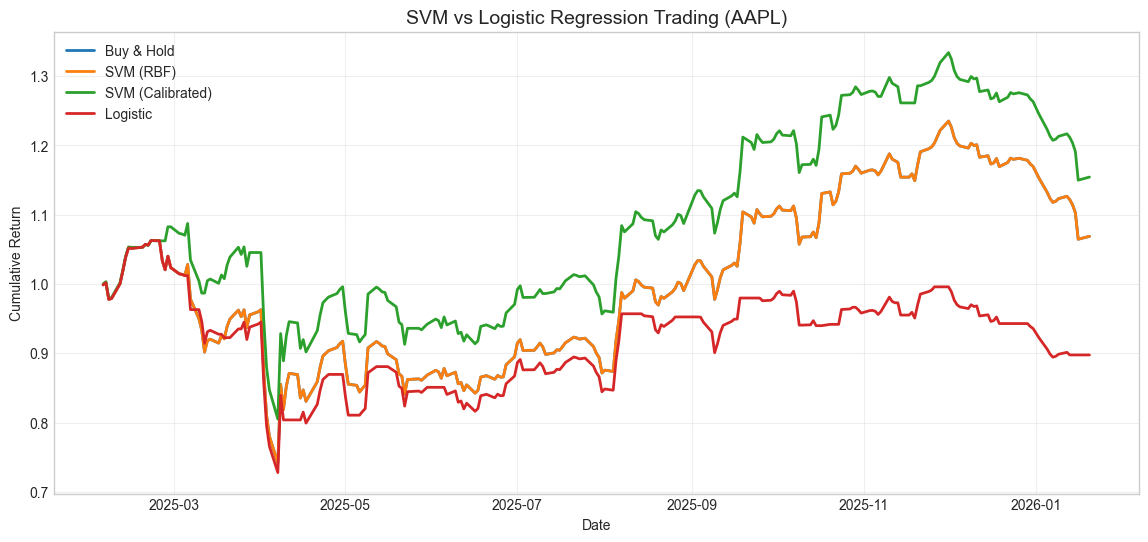

In [10]:
# Trading Strategy Backtest
backtest = pd.DataFrame(index=y_test.index)
backtest['actual_return'] = returns_test.values

for name in models.keys():
    backtest[f'{name}_signal'] = predictions[name]
    backtest[f'{name}_return'] = backtest[f'{name}_signal'] * backtest['actual_return']
    backtest[f'{name}_cum'] = (1 + backtest[f'{name}_return']).cumprod()

backtest['buy_hold_cum'] = (1 + backtest['actual_return']).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2)
for name in models.keys():
    plt.plot(backtest.index, backtest[f'{name}_cum'], label=name, linewidth=2)
plt.title(f'SVM vs Logistic Regression Trading ({target_stock})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
# Performance Summary
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

print(f"\n{'Strategy':<20} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 55)

total, sharpe, mdd = calc_metrics(backtest['actual_return'], backtest['buy_hold_cum'])
print(f"{'Buy & Hold':<20} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%}")

for name in models.keys():
    total, sharpe, mdd = calc_metrics(backtest[f'{name}_return'], backtest[f'{name}_cum'])
    print(f"{name:<20} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%}")


STRATEGY PERFORMANCE

Strategy                Total Ret     Sharpe     Max DD
-------------------------------------------------------
Buy & Hold                  6.86%       0.22    -30.22%
SVM (RBF)                   6.86%       0.22    -30.22%
SVM (Calibrated)           15.41%       0.47    -25.95%
Logistic                  -10.25%      -0.41    -31.51%


In [12]:
# Next Day Prediction
latest_scaled = scaler.transform(X.iloc[[-1]])

print("\n" + "="*60)
print(f"📊 NEXT DAY PREDICTIONS FOR {target_stock}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")

for name, model in models.items():
    pred = model.predict(latest_scaled)[0]
    proba = model.predict_proba(latest_scaled)[0, 1]
    signal = '📈 UP' if pred == 1 else '📉 DOWN'
    print(f"{name:<20}: {signal} (Prob: {proba:.2%})")


📊 NEXT DAY PREDICTIONS FOR AAPL

Date: 2026-01-20
SVM (RBF)           : 📈 UP (Prob: 54.35%)
SVM (Calibrated)    : 📈 UP (Prob: 54.86%)
Logistic            : 📉 DOWN (Prob: 48.79%)


---

## 🏢 Real-World Applications

| Company | SVM Use Case |
|---------|-------------|
| DE Shaw | Non-linear pattern recognition |
| Two Sigma | Regime classification |
| Citadel | Market microstructure signals |
| Man AHL | Trend following classification |

### Key Interview Points
1. **Why SVM over Logistic?** - Better for non-linear patterns, handles high dimensions
2. **Kernel choice?** - RBF for general non-linearity, Linear when data is separable
3. **Scaling importance?** - SVM is sensitive to scale, always standardize!
4. **Probability calibration?** - Use Platt scaling or isotonic regression

---
## 📅 Tomorrow: Triple-Barrier Labeling Method